# YOLOv11 Training Notebook - RGB

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/user/Shivam/dsr_project/Project_files


In [3]:
%pip install "ultralytics==8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
Setup complete ✅ (32 CPUs, 125.5 GB RAM, 1766.1/1832.2 GB disk)


## Load Pretrained YOLO v11n model and Validate

In [2]:
from ultralytics import YOLO
from PIL import Image

# Load the YOLO model
model = YOLO('yolo11n.pt')

# Open the local image file
image = Image.open(r'/home/user/Shivam/dsr_project/dataset/RGB_od/images/test/flir_1662.jpg')

# Perform prediction
result = model.predict(image, conf=0.25)[0]


0: 480x640 1 car, 24.1ms
Speed: 3.6ms preprocess, 24.1ms inference, 38.8ms postprocess per image at shape (1, 3, 480, 640)


In [3]:
result.boxes.xyxy

tensor([[394.4687, 111.5943, 639.4684, 226.7017]], device='cuda:0')

In [4]:
result.boxes.conf

tensor([0.9350], device='cuda:0')

In [5]:
result.boxes.cls

tensor([2.], device='cuda:0')

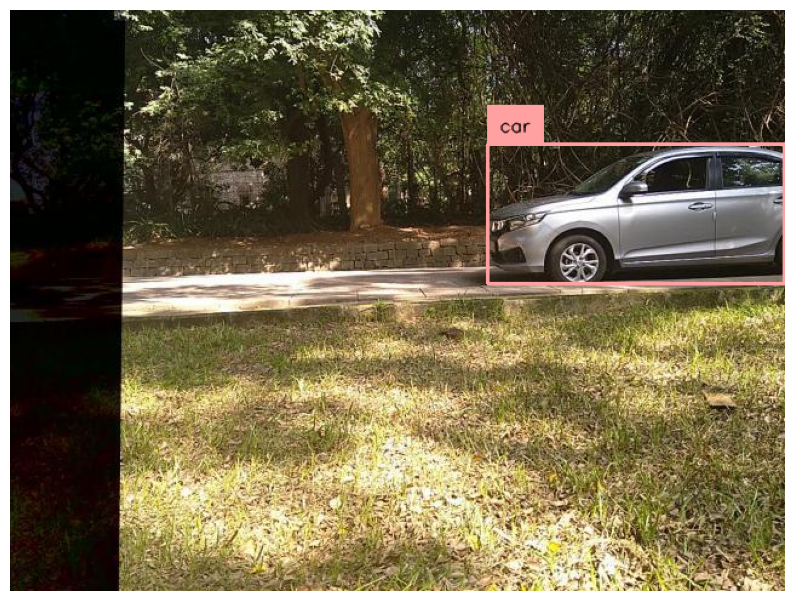

In [6]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Dataset preparation

In [11]:
import yaml
from pathlib import Path

# === CONFIGURATION ===
dataset_root = Path("/home/user/Shivam/dsr_project/dataset/RGB_od")  # dataset root
yaml_save_path = dataset_root / "data.yaml"

# Define class names
class_names = [
    "Person", "Car", "Vehicle_Other", "JCB", "Two_Wheeler", "Dont_Care",
    "Soldier", "Soldier_Camo", "Vehicle_Military", "Tank", "Artillery",
    "Weapon", "Trenches", "Air_Asset", "Naval_Asset"
]

# YAML structure
data = {
    "path": str(dataset_root),  # root path to dataset
    "train": "images/train",    # relative paths
    "val": "images/val",
    "test": "images/test",
    "names": {i: name for i, name in enumerate(class_names)}  # index:name format
}

# Write YAML
with open(yaml_save_path, "w") as f:
    yaml.dump(data, f, sort_keys=False)

print(f"✅ YOLOv11-compatible data.yaml created at: {yaml_save_path}")

✅ YOLOv11-compatible data.yaml created at: /home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml


## Training YOLO v11n Model

In [7]:
from ultralytics import YOLO

# Load a pretrained YOLOv11 model (nano version)
model = YOLO('yolo11n.pt')

# Train the model
results = model.train(
    data="/home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml",  
    epochs=100,
    imgsz=640,
    batch=32,
    name='train',  # subfolder name under yolov11_rgb
    project="/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb",
    workers=4,
    verbose=True
)

New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augme

train: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/train.cache... 21816 images, 669 backgrounds, 1 corrupt: 100%|██████████| 21816/21816 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/user/Shivam/dsr_project/dataset/RGB_od/images/train/000003.jpg: ignoring corrupt image/label: could not convert string to float: 'camouflage_soldier.334375'
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 13, len(boxes) = 49241. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/val.cache... 6233 images, 205 backgrounds, 0 corrupt: 100%|██████████| 6233/6233 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 9, len(boxes) = 13925. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.13G      1.338       2.91      1.387         89        640: 100%|██████████| 682/682 [00:48<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.77it/s]


                   all       6233      13925      0.549      0.401      0.393       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.25G       1.35      1.993      1.365         82        640: 100%|██████████| 682/682 [00:47<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 12.93it/s]


                   all       6233      13925      0.476      0.317      0.312      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.95G      1.436      1.955      1.422        115        640: 100%|██████████| 682/682 [00:46<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 12.90it/s]


                   all       6233      13925      0.408      0.259      0.218      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.85G      1.504      1.884      1.476        110        640: 100%|██████████| 682/682 [00:46<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.04it/s]


                   all       6233      13925      0.504      0.348      0.346      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.38G      1.442      1.682      1.431         72        640: 100%|██████████| 682/682 [00:46<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.04it/s]


                   all       6233      13925      0.463      0.403      0.404      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.96G      1.389      1.549      1.393        111        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.12it/s]


                   all       6233      13925      0.531      0.423      0.444      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       5.5G      1.362       1.48      1.372        103        640: 100%|██████████| 682/682 [00:46<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 12.92it/s]


                   all       6233      13925      0.554      0.437      0.464      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.24G      1.332      1.422      1.357         85        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.03it/s]


                   all       6233      13925      0.553      0.472      0.503      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.98G      1.321      1.376      1.343        100        640: 100%|██████████| 682/682 [00:46<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 12.86it/s]


                   all       6233      13925      0.554      0.474      0.508      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.21G      1.305      1.322      1.325         84        640: 100%|██████████| 682/682 [00:46<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.18it/s]


                   all       6233      13925      0.591      0.505      0.532      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.89G      1.286      1.299      1.319         81        640: 100%|██████████| 682/682 [00:46<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.21it/s]


                   all       6233      13925      0.615      0.514      0.552      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.46G       1.27      1.269      1.306         74        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.10it/s]


                   all       6233      13925      0.597      0.509      0.551      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.43G      1.257      1.241      1.295         57        640: 100%|██████████| 682/682 [00:46<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.26it/s]


                   all       6233      13925      0.614      0.539      0.579      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.24G      1.248      1.215      1.291         89        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.18it/s]


                   all       6233      13925      0.596      0.531      0.578      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.27G      1.239        1.2      1.281        117        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.26it/s]


                   all       6233      13925      0.747      0.541      0.597      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.03G      1.232      1.179      1.277         95        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.24it/s]


                   all       6233      13925       0.73      0.547      0.599      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.04G      1.226      1.176      1.276         84        640: 100%|██████████| 682/682 [00:46<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.05it/s]


                   all       6233      13925      0.716       0.57      0.614      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.09G      1.216      1.155      1.265         78        640: 100%|██████████| 682/682 [00:46<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.19it/s]


                   all       6233      13925      0.749      0.564      0.615      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.43G      1.205      1.143      1.262        121        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.25it/s]


                   all       6233      13925      0.747      0.564      0.623      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.76G      1.198      1.124      1.253         89        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.24it/s]


                   all       6233      13925      0.727       0.59      0.637      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.18G      1.194       1.11      1.251        109        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.28it/s]


                   all       6233      13925      0.749      0.583      0.637       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.61G      1.189      1.105      1.247         84        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.23it/s]


                   all       6233      13925      0.754      0.588      0.662      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.99G      1.185        1.1      1.249         73        640: 100%|██████████| 682/682 [00:46<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.27it/s]


                   all       6233      13925      0.768      0.585      0.644      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.77G      1.179       1.09      1.243         82        640: 100%|██████████| 682/682 [00:46<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.27it/s]


                   all       6233      13925      0.767      0.592      0.647       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.47G      1.177      1.078      1.244         94        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.12it/s]


                   all       6233      13925      0.762      0.602      0.656      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.86G      1.175      1.072      1.238         73        640: 100%|██████████| 682/682 [00:46<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.05it/s]


                   all       6233      13925      0.782        0.6       0.66      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.51G      1.167      1.055       1.23         98        640: 100%|██████████| 682/682 [00:46<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.23it/s]


                   all       6233      13925      0.761      0.602      0.659      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.46G       1.15      1.045      1.223         86        640: 100%|██████████| 682/682 [00:46<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.05it/s]

                   all       6233      13925      0.787      0.602      0.668      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.06G      1.152      1.036      1.227        119        640: 100%|██████████| 682/682 [00:46<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.12it/s]

                   all       6233      13925      0.782      0.612      0.671       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.59G      1.155      1.043      1.227         93        640: 100%|██████████| 682/682 [00:46<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.24it/s]


                   all       6233      13925      0.785      0.607      0.672      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       6.1G      1.144      1.022      1.219         81        640: 100%|██████████| 682/682 [00:46<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.26it/s]


                   all       6233      13925      0.779      0.614      0.683      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.51G      1.142       1.02      1.215         99        640: 100%|██████████| 682/682 [00:46<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.30it/s]


                   all       6233      13925      0.786      0.621      0.695       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.77G      1.142      1.011      1.213        128        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.20it/s]

                   all       6233      13925      0.803      0.613      0.698       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.72G      1.138      1.011      1.208         91        640: 100%|██████████| 682/682 [00:46<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.10it/s]


                   all       6233      13925      0.789      0.618      0.698       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.05G      1.135      1.001      1.209        101        640: 100%|██████████| 682/682 [00:46<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.32it/s]


                   all       6233      13925      0.789      0.628      0.701      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.64G      1.124     0.9947      1.204         85        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.26it/s]

                   all       6233      13925      0.792      0.624      0.688      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.87G      1.119     0.9816      1.201        109        640: 100%|██████████| 682/682 [00:46<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.23it/s]

                   all       6233      13925      0.789       0.63      0.694      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.25G      1.118     0.9858      1.202         96        640: 100%|██████████| 682/682 [00:46<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.17it/s]

                   all       6233      13925      0.802      0.624      0.709      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.77G      1.122     0.9748        1.2        110        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.27it/s]

                   all       6233      13925      0.801      0.626      0.711      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.45G      1.111     0.9672      1.197        105        640: 100%|██████████| 682/682 [00:46<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 12.81it/s]


                   all       6233      13925      0.808      0.628      0.711      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.84G      1.112      0.963      1.198         90        640: 100%|██████████| 682/682 [01:15<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]

                   all       6233      13925      0.801      0.634      0.714      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.23G      1.101     0.9495      1.189         72        640: 100%|██████████| 682/682 [01:20<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]

                   all       6233      13925      0.812      0.626      0.715      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.89G      1.106      0.949      1.191        117        640: 100%|██████████| 682/682 [01:15<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]

                   all       6233      13925      0.818      0.623      0.715      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.86G      1.099     0.9443      1.188        104        640: 100%|██████████| 682/682 [01:15<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:33<00:00,  2.88it/s]

                   all       6233      13925      0.815      0.627      0.716        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       5.4G      1.098      0.943      1.186        144        640: 100%|██████████| 682/682 [01:17<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]

                   all       6233      13925      0.809      0.632      0.716      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.45G      1.095     0.9371      1.184        100        640: 100%|██████████| 682/682 [01:17<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:33<00:00,  2.97it/s]

                   all       6233      13925      0.803      0.635      0.717      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.06G      1.091     0.9308      1.181         78        640: 100%|██████████| 682/682 [01:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]

                   all       6233      13925      0.799      0.641      0.718      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.34G      1.086     0.9159      1.177         75        640: 100%|██████████| 682/682 [01:21<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]

                   all       6233      13925      0.799      0.641      0.719      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.55G      1.088     0.9224      1.176         65        640: 100%|██████████| 682/682 [01:17<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]

                   all       6233      13925      0.798      0.643       0.72      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.28G      1.084     0.9193      1.178        101        640: 100%|██████████| 682/682 [01:22<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]

                   all       6233      13925      0.802       0.64      0.721      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.66G      1.081     0.9076      1.173         90        640: 100%|██████████| 682/682 [01:23<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]

                   all       6233      13925      0.796      0.648      0.722      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.34G      1.073     0.9008      1.169         94        640: 100%|██████████| 682/682 [01:19<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]

                   all       6233      13925      0.795       0.65      0.723      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.08G      1.073     0.9072      1.171        105        640: 100%|██████████| 682/682 [01:23<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]

                   all       6233      13925      0.796      0.648      0.723      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.43G       1.07      0.894      1.169         62        640: 100%|██████████| 682/682 [01:25<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]

                   all       6233      13925      0.795       0.65      0.724      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.62G      1.068     0.8883      1.166        124        640: 100%|██████████| 682/682 [01:21<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]

                   all       6233      13925      0.697      0.716      0.725      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.79G      1.064     0.8788      1.163         87        640: 100%|██████████| 682/682 [01:21<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]

                   all       6233      13925      0.694      0.717      0.725       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.09G      1.063     0.8863      1.162        112        640: 100%|██████████| 682/682 [01:22<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]

                   all       6233      13925      0.695      0.717      0.726      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.37G      1.052     0.8699      1.157         84        640: 100%|██████████| 682/682 [01:27<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]

                   all       6233      13925      0.691      0.716      0.727       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.01G      1.054      0.874      1.159        113        640: 100%|██████████| 682/682 [01:23<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]

                   all       6233      13925      0.689      0.717      0.727      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.16G       1.05      0.866      1.154        151        640: 100%|██████████| 682/682 [01:24<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]

                   all       6233      13925      0.693      0.717      0.728      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.41G      1.041     0.8549      1.151         86        640: 100%|██████████| 682/682 [01:22<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]

                   all       6233      13925      0.687      0.717      0.728      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.39G      1.041     0.8596      1.152        100        640: 100%|██████████| 682/682 [01:24<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]

                   all       6233      13925      0.687      0.717      0.728      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.38G      1.043     0.8543      1.156        129        640: 100%|██████████| 682/682 [01:24<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]

                   all       6233      13925      0.687      0.716      0.729      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.39G       1.04     0.8481      1.145         90        640: 100%|██████████| 682/682 [01:29<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]

                   all       6233      13925      0.694      0.714      0.729      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.71G      1.038     0.8453      1.149        101        640: 100%|██████████| 682/682 [01:25<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]

                   all       6233      13925      0.699      0.713       0.73      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.44G      1.029     0.8352      1.145         58        640: 100%|██████████| 682/682 [01:28<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]

                   all       6233      13925        0.7      0.713      0.731      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.46G      1.027     0.8336      1.144        104        640: 100%|██████████| 682/682 [01:27<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]

                   all       6233      13925      0.697      0.714      0.731      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.05G      1.026     0.8243      1.142        101        640: 100%|██████████| 682/682 [01:25<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]

                   all       6233      13925       0.69      0.719      0.732      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.85G      1.022     0.8261       1.14         75        640: 100%|██████████| 682/682 [01:26<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]

                   all       6233      13925      0.687      0.721      0.733      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.67G      1.021      0.819      1.136         54        640: 100%|██████████| 682/682 [01:26<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]

                   all       6233      13925      0.687       0.72      0.734      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       5.4G      1.017     0.8176      1.134         96        640: 100%|██████████| 682/682 [01:27<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]

                   all       6233      13925      0.685      0.723      0.734      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.57G      1.013     0.8047      1.137         83        640: 100%|██████████| 682/682 [01:34<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]

                   all       6233      13925      0.686      0.722      0.735       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         6G      1.012     0.8006      1.134         72        640: 100%|██████████| 682/682 [01:29<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]

                   all       6233      13925      0.684      0.722      0.736       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.41G      1.009     0.7962       1.13        108        640: 100%|██████████| 682/682 [01:27<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]

                   all       6233      13925      0.682      0.721      0.736      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.99G      1.008     0.7933       1.13        101        640: 100%|██████████| 682/682 [01:35<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]

                   all       6233      13925      0.679      0.721      0.737      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       5.7G     0.9991     0.7887      1.126        104        640: 100%|██████████| 682/682 [01:27<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]

                   all       6233      13925      0.682      0.721      0.737      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.55G      0.998     0.7812      1.127        110        640: 100%|██████████| 682/682 [01:29<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]

                   all       6233      13925      0.684      0.721      0.738      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.59G     0.9907     0.7786      1.122        100        640: 100%|██████████| 682/682 [01:27<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]

                   all       6233      13925      0.684      0.721      0.739      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.77G     0.9914     0.7785      1.123         86        640: 100%|██████████| 682/682 [01:28<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]

                   all       6233      13925      0.681      0.722      0.739      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.93G     0.9889     0.7717      1.121         85        640: 100%|██████████| 682/682 [01:29<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]

                   all       6233      13925      0.683      0.722       0.74      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       5.4G     0.9844     0.7662      1.119         90        640: 100%|██████████| 682/682 [01:36<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.28it/s]

                   all       6233      13925      0.683      0.723       0.74       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.67G     0.9819     0.7618      1.118         79        640: 100%|██████████| 682/682 [01:28<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.29it/s]

                   all       6233      13925      0.691      0.723      0.741      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       5.4G     0.9779     0.7569      1.114         93        640: 100%|██████████| 682/682 [01:36<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.28it/s]

                   all       6233      13925      0.687      0.723      0.741      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.01G     0.9696     0.7495       1.11         68        640: 100%|██████████| 682/682 [01:30<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]

                   all       6233      13925      0.685      0.723      0.742      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.49G      0.968     0.7428       1.11         99        640: 100%|██████████| 682/682 [01:28<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.16it/s]

                   all       6233      13925      0.689      0.724      0.742      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.46G     0.9674     0.7425      1.108         67        640: 100%|██████████| 682/682 [01:28<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]

                   all       6233      13925      0.694      0.722      0.743      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.13G     0.9619     0.7336      1.106         94        640: 100%|██████████| 682/682 [01:32<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.27it/s]

                   all       6233      13925      0.696      0.724      0.743      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.17G     0.9573     0.7327      1.104         71        640: 100%|██████████| 682/682 [01:37<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.27it/s]

                   all       6233      13925      0.702      0.723      0.744      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.75G     0.9578     0.7285      1.102        114        640: 100%|██████████| 682/682 [01:28<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.30it/s]

                   all       6233      13925      0.708      0.723      0.745      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.57G     0.9489     0.7228      1.098        117        640: 100%|██████████| 682/682 [01:28<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.30it/s]

                   all       6233      13925      0.712      0.722      0.745      0.524


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.39G     0.8954      0.607      1.077         44        640: 100%|██████████| 682/682 [01:28<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]

                   all       6233      13925      0.716      0.721      0.746      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.47G     0.8779     0.5879      1.067         38        640: 100%|██████████| 682/682 [01:28<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.33it/s]

                   all       6233      13925      0.717       0.72      0.746      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       5.3G     0.8682     0.5802       1.06         64        640: 100%|██████████| 682/682 [01:31<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]

                   all       6233      13925      0.717      0.721      0.747      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.63G     0.8655     0.5716      1.058         62        640: 100%|██████████| 682/682 [01:28<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]

                   all       6233      13925      0.716       0.72      0.747      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.11G     0.8572     0.5654      1.054         45        640: 100%|██████████| 682/682 [01:34<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.35it/s]

                   all       6233      13925      0.713       0.72      0.748      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.85G     0.8532     0.5602      1.049         49        640: 100%|██████████| 682/682 [01:28<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.25it/s]

                   all       6233      13925      0.715       0.72      0.749      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.81G      0.846     0.5522      1.046         51        640: 100%|██████████| 682/682 [01:30<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.29it/s]

                   all       6233      13925      0.716      0.719      0.749      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.52G     0.8424     0.5456      1.044         70        640: 100%|██████████| 682/682 [01:29<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]

                   all       6233      13925      0.719      0.719      0.749       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.75G     0.8352     0.5406       1.04         44        640: 100%|██████████| 682/682 [01:28<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]

                   all       6233      13925      0.724      0.717      0.749      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       5.7G     0.8311     0.5384       1.04         34        640: 100%|██████████| 682/682 [01:28<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:18<00:00,  5.23it/s]

                   all       6233      13925      0.725      0.718       0.75      0.531



100 epochs completed in 2.443 hours.
Optimizer stripped from /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train/weights/last.pt, 5.5MB
Optimizer stripped from /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train/weights/best.pt, 5.5MB

Validating /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11n summary (fused): 238 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


                   all       6233      13925      0.725      0.718       0.75      0.531
                Person        418        807      0.795      0.814      0.879      0.562
                   Car        530       2658      0.738      0.891      0.904      0.713
         Vehicle_Other        314        403      0.825      0.831      0.896      0.679
               Soldier        642       1501       0.71      0.552      0.622       0.38
          Soldier_Camo        806       1069      0.824       0.87      0.886      0.565
      Vehicle_Military        354        775      0.586      0.592      0.627      0.458
                  Tank       1995       3939      0.813      0.893      0.906      0.653
             Artillery         73        103      0.688      0.476      0.547      0.386
                Weapon        222        361      0.741      0.734      0.777      0.566
              Trenches          4          4       0.35       0.25      0.246     0.0824
             Air_Asse

## Testing YOLO v11n Model

In [8]:
from ultralytics import YOLO

# Load trained model
model = YOLO('/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train/weights/best.pt')

# Evaluate on test set
metrics = model.val(
    split='test',
    name='test',  #  separate subfolder for test
    project="/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb"
)

# Print test metrics
print(metrics)

Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)


YOLO11n summary (fused): 238 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/test.cache... 3117 images, 89 backgrounds, 0 corrupt: 100%|██████████| 3117/3117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:22<00:00,  8.61it/s]


                   all       3117       7164      0.808      0.744      0.798      0.581
                Person        207        427      0.824      0.756      0.859      0.543
                   Car        266       1390      0.776      0.875      0.894      0.704
         Vehicle_Other        141        214      0.853      0.813      0.854      0.654
               Soldier        369        837       0.82      0.526      0.635      0.372
          Soldier_Camo        403        524      0.872      0.868      0.927      0.598
      Vehicle_Military        181        414      0.671      0.592      0.656       0.49
                  Tank        996       1954      0.838      0.889      0.908      0.662
             Artillery         41         76      0.732      0.408      0.486      0.345
                Weapon         91        118      0.795      0.758      0.826      0.656
             Air_Asset        491       1007      0.903      0.766      0.856      0.665
           Naval_Asse

## Load Pretrained YOLO v11m model and Validate

In [2]:
import urllib.request

# URL of the model
url = "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11m.pt"
save_path = "/home/user/Shivam/dsr_project/Project_files/yolo11m.pt"

# Download the model
urllib.request.urlretrieve(url, save_path)
print("✅ yolo11m.pt downloaded successfully.")

✅ yolo11m.pt downloaded successfully.


In [3]:
from ultralytics import YOLO
from PIL import Image

# Load the YOLO model
model = YOLO('yolo11m.pt')

# Open the local image file
image = Image.open(r'/home/user/Shivam/dsr_project/dataset/RGB_od/images/test/flir_1662.jpg')

# Perform prediction
result = model.predict(image, conf=0.25)[0]


0: 480x640 1 car, 25.0ms
Speed: 2.7ms preprocess, 25.0ms inference, 46.0ms postprocess per image at shape (1, 3, 480, 640)


In [4]:
result.boxes.xyxy

tensor([[392.6438, 112.4612, 639.6879, 227.2384]], device='cuda:0')

In [5]:
result.boxes.conf

tensor([0.9414], device='cuda:0')

In [6]:
result.boxes.cls

tensor([2.], device='cuda:0')

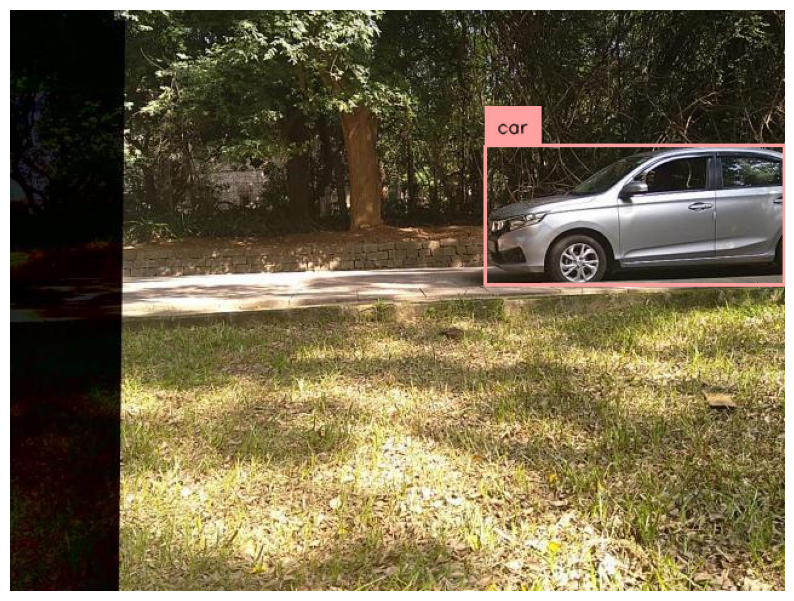

In [7]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Training YOLO v11m Model

In [8]:
from ultralytics import YOLO

# Load a pretrained YOLOv11 model (medium version)
model = YOLO('yolo11m.pt')

# Train the model
results = model.train(
    data="/home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml",  
    epochs=100,
    imgsz=640,
    batch=16,
    name='train11m',  # subfolder name under yolov11_rgb
    project="/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb",
    workers=4,
    verbose=True
)

New https://pypi.org/project/ultralytics/8.3.122 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb, name=train11m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, au

train: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/train.cache... 21816 images, 669 backgrounds, 1 corrupt: 100%|██████████| 21816/21816 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/user/Shivam/dsr_project/dataset/RGB_od/images/train/000003.jpg: ignoring corrupt image/label: could not convert string to float: 'camouflage_soldier.334375'
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 13, len(boxes) = 49241. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/val.cache... 6233 images, 205 backgrounds, 0 corrupt: 100%|██████████| 6233/6233 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 9, len(boxes) = 13925. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11m
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.62G      1.168      1.657      1.287         54        640: 100%|██████████| 1364/1364 [02:29<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:14<00:00, 13.09it/s]


                   all       6233      13925      0.624      0.474      0.491       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.54G      1.233       1.31      1.308         21        640: 100%|██████████| 1364/1364 [02:25<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:14<00:00, 13.29it/s]


                   all       6233      13925      0.473      0.447      0.454      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.63G      1.388      1.563      1.416         15        640: 100%|██████████| 1364/1364 [02:24<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:14<00:00, 13.25it/s]


                   all       6233      13925      0.485      0.347      0.334      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.55G      1.452      1.674      1.474         27        640: 100%|██████████| 1364/1364 [04:43<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:47<00:00,  4.11it/s]


                   all       6233      13925      0.527      0.347       0.36      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.58G      1.373      1.522      1.422         17        640: 100%|██████████| 1364/1364 [04:52<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:48<00:00,  4.04it/s]


                   all       6233      13925        0.6      0.449      0.458      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.57G      1.319      1.404      1.385         15        640: 100%|██████████| 1364/1364 [04:45<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:47<00:00,  4.11it/s]


                   all       6233      13925      0.653      0.487      0.519      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       8.6G      1.285      1.325      1.358         18        640: 100%|██████████| 1364/1364 [04:44<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:48<00:00,  4.06it/s]


                   all       6233      13925       0.69      0.512      0.544      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.56G      1.251      1.267      1.336         52        640: 100%|██████████| 1364/1364 [04:45<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:47<00:00,  4.10it/s]


                   all       6233      13925      0.699      0.519      0.562      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.55G      1.229      1.232      1.322         25        640: 100%|██████████| 1364/1364 [04:52<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:46<00:00,  4.16it/s]


                   all       6233      13925      0.592      0.546      0.576      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.55G      1.205      1.179      1.302         34        640: 100%|██████████| 1364/1364 [04:51<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:46<00:00,  4.16it/s]


                   all       6233      13925      0.729      0.564      0.603      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.56G      1.184      1.137      1.293         20        640: 100%|██████████| 1364/1364 [04:52<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:46<00:00,  4.15it/s]


                   all       6233      13925      0.733      0.567      0.616      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.73G      1.176      1.115      1.289         18        640: 100%|██████████| 1364/1364 [04:51<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:46<00:00,  4.18it/s]


                   all       6233      13925      0.755      0.579       0.63      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.52G       1.16      1.094      1.277         25        640: 100%|██████████| 1364/1364 [04:46<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:46<00:00,  4.21it/s]


                   all       6233      13925      0.734      0.597      0.639      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.58G      1.141      1.068      1.266         21        640: 100%|██████████| 1364/1364 [04:52<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:46<00:00,  4.20it/s]


                   all       6233      13925      0.749      0.585      0.647      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.55G      1.131      1.054      1.259         25        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.33it/s]


                   all       6233      13925       0.77      0.591      0.653      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.51G      1.123      1.034      1.252         40        640: 100%|██████████| 1364/1364 [04:48<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:45<00:00,  4.31it/s]


                   all       6233      13925      0.775      0.593      0.661      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.55G      1.114      1.009      1.245         42        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.42it/s]


                   all       6233      13925      0.774      0.615       0.68      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.56G      1.102     0.9962      1.237         14        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.45it/s]


                   all       6233      13925      0.772      0.622      0.672      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.56G      1.093     0.9847      1.234         16        640: 100%|██████████| 1364/1364 [04:48<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.40it/s]


                   all       6233      13925      0.787       0.62      0.678      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.57G      1.083     0.9612      1.224         77        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.42it/s]

                   all       6233      13925      0.797      0.621      0.694      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.57G      1.081     0.9521      1.222         22        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925       0.81      0.622      0.695      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.55G      1.074     0.9479      1.222         34        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.45it/s]

                   all       6233      13925      0.792      0.635      0.699      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.56G      1.067     0.9328      1.212         40        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.45it/s]


                   all       6233      13925      0.797      0.644      0.705      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       8.9G      1.059     0.9223      1.209         41        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.42it/s]

                   all       6233      13925      0.795      0.647      0.703        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.55G      1.052     0.9117      1.209         30        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925      0.812      0.647      0.714      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.55G      1.041     0.9004      1.199         55        640: 100%|██████████| 1364/1364 [04:57<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.48it/s]

                   all       6233      13925      0.799      0.665      0.716      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.55G      1.035     0.8881      1.195         25        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.49it/s]

                   all       6233      13925      0.807      0.665      0.716      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.54G      1.027     0.8804       1.19         22        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925      0.802      0.679      0.727      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.52G      1.033     0.8713      1.196         40        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.49it/s]

                   all       6233      13925      0.814      0.679      0.728      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       8.5G      1.017     0.8619      1.184         32        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.41it/s]

                   all       6233      13925      0.821      0.666       0.73      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.55G      1.017     0.8464       1.18         22        640: 100%|██████████| 1364/1364 [04:57<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.49it/s]

                   all       6233      13925      0.816       0.68      0.738      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.49G      1.012     0.8466      1.178         25        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.48it/s]

                   all       6233      13925      0.817      0.686      0.742      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.55G      1.004     0.8384      1.173         20        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.59it/s]

                   all       6233      13925      0.816       0.69      0.746      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       8.5G      1.005     0.8283      1.172         35        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925      0.808      0.694      0.758       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.57G      0.997     0.8204      1.173         34        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.59it/s]

                   all       6233      13925      0.822      0.685      0.742      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.56G     0.9925     0.8155      1.167         22        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.50it/s]

                   all       6233      13925       0.82      0.684       0.74       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.56G     0.9854     0.8113      1.167         26        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.50it/s]

                   all       6233      13925       0.82      0.685      0.742      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.55G     0.9817     0.7987      1.163         39        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.44it/s]

                   all       6233      13925      0.823      0.684      0.745      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       8.5G     0.9803     0.7947      1.161         17        640: 100%|██████████| 1364/1364 [04:57<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.56it/s]

                   all       6233      13925      0.833      0.679      0.749      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.55G     0.9739     0.7869      1.155         29        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925      0.833      0.684      0.749      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.72G     0.9706     0.7828      1.156         30        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.52it/s]

                   all       6233      13925      0.745       0.69      0.751      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.54G     0.9649     0.7692      1.148         27        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.50it/s]

                   all       6233      13925      0.746      0.692      0.752      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.79G     0.9608     0.7681      1.149         29        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.53it/s]

                   all       6233      13925      0.741      0.694      0.752      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.58G     0.9531     0.7637      1.144         29        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.50it/s]

                   all       6233      13925      0.743      0.693      0.753      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.5G     0.9486     0.7524      1.144         26        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.53it/s]

                   all       6233      13925      0.728      0.709      0.756      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.51G     0.9483     0.7469      1.139         34        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.43it/s]

                   all       6233      13925      0.703      0.745      0.759      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.53G     0.9432      0.742      1.139         21        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.52it/s]

                   all       6233      13925      0.704      0.749      0.759      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.55G     0.9384     0.7345      1.134         17        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925      0.703      0.749       0.76      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.55G     0.9322     0.7228      1.128         24        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.52it/s]

                   all       6233      13925        0.7       0.75       0.76      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.49G      0.928     0.7238      1.128         48        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.50it/s]

                   all       6233      13925      0.708      0.748      0.761      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.56G     0.9285     0.7184      1.127         31        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.46it/s]

                   all       6233      13925      0.712      0.748      0.762      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       8.5G     0.9176     0.7037       1.12         15        640: 100%|██████████| 1364/1364 [04:48<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.46it/s]

                   all       6233      13925      0.717      0.746      0.762      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.51G     0.9157     0.7033      1.121         17        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925       0.72      0.744      0.763      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.53G     0.9084     0.6953      1.118         27        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925       0.72      0.747      0.763      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.56G     0.9039     0.6934      1.115         33        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.45it/s]

                   all       6233      13925      0.719      0.745      0.763      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.55G     0.9028     0.6848      1.113         23        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.43it/s]

                   all       6233      13925      0.722      0.743      0.764      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.55G     0.9005     0.6801      1.111         40        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.51it/s]

                   all       6233      13925       0.72      0.747      0.764      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.53G     0.8903     0.6707      1.106         39        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:44<00:00,  4.40it/s]

                   all       6233      13925       0.72      0.749      0.765      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.52G     0.8917     0.6737      1.106         15        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.51it/s]

                   all       6233      13925      0.724      0.751      0.765      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.56G     0.8863     0.6636      1.105         65        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.53it/s]

                   all       6233      13925       0.72      0.752      0.766       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.56G     0.8818     0.6588        1.1         18        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.52it/s]

                   all       6233      13925      0.721      0.752      0.766       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.57G      0.878     0.6535      1.102         41        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.51it/s]

                   all       6233      13925      0.722      0.751      0.767      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.57G      0.873     0.6508      1.097         25        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.56it/s]

                   all       6233      13925      0.718      0.751      0.767      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.56G     0.8718     0.6461      1.095         15        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.58it/s]

                   all       6233      13925      0.715      0.752      0.767      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.54G     0.8628     0.6377      1.089         26        640: 100%|██████████| 1364/1364 [04:48<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.52it/s]

                   all       6233      13925       0.71      0.755      0.768      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.57G     0.8571     0.6306      1.084         46        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.47it/s]

                   all       6233      13925      0.709      0.757      0.768      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.58G     0.8531     0.6328      1.087         29        640: 100%|██████████| 1364/1364 [04:48<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.46it/s]

                   all       6233      13925      0.709      0.758      0.768      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.58G     0.8554     0.6243      1.086         15        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.54it/s]

                   all       6233      13925      0.711      0.759      0.768      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.56G     0.8441     0.6121      1.081         21        640: 100%|██████████| 1364/1364 [04:54<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.56it/s]

                   all       6233      13925      0.712      0.764      0.769      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.57G     0.8421     0.6114      1.077         30        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.48it/s]

                   all       6233      13925      0.712      0.766       0.77      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.57G     0.8323     0.6029      1.074         23        640: 100%|██████████| 1364/1364 [04:57<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.57it/s]

                   all       6233      13925      0.713      0.769       0.77      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.56G     0.8342     0.6006      1.073         58        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.55it/s]

                   all       6233      13925      0.711      0.769      0.771      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.57G     0.8276     0.5958      1.072         30        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.56it/s]

                   all       6233      13925      0.708      0.772      0.771      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.55G     0.8215      0.587      1.065         15        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:43<00:00,  4.52it/s]

                   all       6233      13925      0.751      0.754      0.775       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.52G     0.8162     0.5814      1.066         32        640: 100%|██████████| 1364/1364 [04:58<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.58it/s]

                   all       6233      13925      0.755      0.757      0.775       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.55G     0.8186      0.573      1.061         18        640: 100%|██████████| 1364/1364 [04:49<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.55it/s]

                   all       6233      13925      0.755      0.756      0.776      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.56G      0.804     0.5711      1.056         32        640: 100%|██████████| 1364/1364 [04:55<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.60it/s]

                   all       6233      13925      0.754      0.756      0.776      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.56G     0.8032     0.5673      1.059         62        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.58it/s]

                   all       6233      13925      0.761      0.754      0.776      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.53G     0.7958     0.5658      1.056         21        640: 100%|██████████| 1364/1364 [04:57<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:42<00:00,  4.58it/s]

                   all       6233      13925      0.762      0.753      0.777      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.56G     0.7979     0.5604      1.051         23        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]

                   all       6233      13925      0.768      0.751      0.777      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.56G     0.7919     0.5508      1.051         81        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.70it/s]

                   all       6233      13925      0.771      0.749      0.777      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.56G     0.7847     0.5469      1.046         39        640: 100%|██████████| 1364/1364 [04:59<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.72it/s]

                   all       6233      13925      0.776      0.747      0.778      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.58G     0.7784     0.5404      1.044         36        640: 100%|██████████| 1364/1364 [04:59<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.71it/s]

                   all       6233      13925      0.778      0.745      0.788      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.56G     0.7798     0.5402      1.043         35        640: 100%|██████████| 1364/1364 [04:59<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.69it/s]

                   all       6233      13925      0.787      0.742      0.788      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.55G     0.7715     0.5339      1.041         31        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.72it/s]

                   all       6233      13925      0.791       0.74      0.789      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.55G      0.764     0.5236      1.038         33        640: 100%|██████████| 1364/1364 [04:51<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]

                   all       6233      13925      0.794      0.739      0.789      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.82G     0.7621      0.523      1.038         51        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.75it/s]

                   all       6233      13925      0.806      0.736       0.79      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.54G     0.7575     0.5179      1.035         26        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.70it/s]

                   all       6233      13925      0.813      0.735       0.79      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.53G     0.7496     0.5108      1.027         32        640: 100%|██████████| 1364/1364 [04:57<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.68it/s]

                   all       6233      13925      0.817      0.735       0.79      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.56G      0.743     0.5061       1.03         27        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]

                   all       6233      13925      0.823      0.734      0.791      0.597


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.53G     0.6727     0.4005     0.9854         14        640: 100%|██████████| 1364/1364 [04:58<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.75it/s]

                   all       6233      13925      0.831      0.732      0.791      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.55G     0.6624       0.39     0.9785         10        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.75it/s]

                   all       6233      13925      0.832      0.734      0.791      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.55G     0.6515      0.381     0.9697         19        640: 100%|██████████| 1364/1364 [04:58<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:40<00:00,  4.80it/s]

                   all       6233      13925      0.838      0.733      0.791      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.55G     0.6438     0.3783     0.9682         18        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.74it/s]

                   all       6233      13925      0.841      0.731      0.792      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.55G     0.6374     0.3709     0.9626         14        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.73it/s]

                   all       6233      13925      0.845      0.729      0.792      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.56G     0.6302     0.3674     0.9605         22        640: 100%|██████████| 1364/1364 [04:51<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.76it/s]

                   all       6233      13925      0.845      0.729      0.792        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.55G     0.6244     0.3606     0.9561          8        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:40<00:00,  4.76it/s]

                   all       6233      13925      0.844      0.729      0.793        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.52G     0.6172     0.3559      0.951         11        640: 100%|██████████| 1364/1364 [04:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.71it/s]

                   all       6233      13925      0.845      0.728      0.793      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.56G      0.614     0.3528      0.951          7        640: 100%|██████████| 1364/1364 [04:58<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:40<00:00,  4.76it/s]

                   all       6233      13925      0.844      0.727      0.793      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.53G     0.6104     0.3489      0.948          8        640: 100%|██████████| 1364/1364 [04:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:41<00:00,  4.66it/s]

                   all       6233      13925      0.843      0.727      0.793      0.602



100 epochs completed in 9.222 hours.
Optimizer stripped from /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11m/weights/last.pt, 40.5MB
Optimizer stripped from /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11m/weights/best.pt, 40.5MB

Validating /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11m/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 303 layers, 20,041,597 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [01:15<00:00,  2.58it/s]


                   all       6233      13925      0.845      0.727      0.793      0.602
                Person        418        807      0.926      0.841       0.94      0.637
                   Car        530       2658      0.834      0.855      0.924      0.749
         Vehicle_Other        314        403      0.909      0.873      0.936      0.737
               Soldier        642       1501      0.823      0.562      0.689      0.445
          Soldier_Camo        806       1069      0.892      0.877      0.926      0.637
      Vehicle_Military        354        775      0.697       0.59      0.671       0.51
                  Tank       1995       3939      0.872      0.881      0.922        0.7
             Artillery         73        103      0.708      0.476      0.598       0.45
                Weapon        222        361      0.887      0.789      0.879       0.69
              Trenches          4          4      0.825       0.25      0.246      0.197
             Air_Asse

## Testing YOLO v11m Model

In [9]:
from ultralytics import YOLO

# Load trained model
model = YOLO('/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11m/weights/best.pt')

# Evaluate on test set
metrics = model.val(
    split='test',
    name='test11m',  #  separate subfolder for test
    project="/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb"
)

# Print test metrics
print(metrics)

Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)


YOLO11m summary (fused): 303 layers, 20,041,597 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/test.cache... 3117 images, 89 backgrounds, 0 corrupt: 100%|██████████| 3117/3117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:47<00:00,  4.08it/s]


                   all       3117       7164      0.843      0.782      0.845      0.646
                Person        207        427      0.865      0.836      0.917      0.618
                   Car        266       1390      0.802      0.858       0.91      0.733
         Vehicle_Other        141        214      0.853      0.841      0.892      0.711
               Soldier        369        837      0.861      0.577      0.705      0.451
          Soldier_Camo        403        524      0.915      0.899      0.947      0.665
      Vehicle_Military        181        414      0.736      0.639      0.738      0.579
                  Tank        996       1954      0.869      0.906      0.929      0.709
             Artillery         41         76       0.71      0.474      0.542      0.379
                Weapon         91        118        0.9      0.839      0.913       0.75
             Air_Asset        491       1007      0.958      0.806      0.896       0.75
           Naval_Asse

## Load Pretrained YOLO v11x model and Validate

In [11]:
import urllib.request

# URL of the model
url = "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11x.pt"
save_path = "yolo11x.pt"

# Download the model
urllib.request.urlretrieve(url, save_path)
print("✅ yolo11x.pt downloaded successfully.")

✅ yolo11x.pt downloaded successfully.


In [12]:
from ultralytics import YOLO
from PIL import Image

# Load the YOLO model
model = YOLO('yolo11x.pt')

# Open the local image file
image = Image.open(r'/home/user/Shivam/dsr_project/dataset/RGB_od/images/test/flir_1662.jpg')

# Perform prediction
result = model.predict(image, conf=0.25)[0]


0: 480x640 1 car, 33.4ms
Speed: 4.4ms preprocess, 33.4ms inference, 11.5ms postprocess per image at shape (1, 3, 480, 640)


In [13]:
result.boxes.xyxy

tensor([[392.7823, 112.6827, 639.7565, 226.6999]], device='cuda:0')

In [14]:
result.boxes.conf

tensor([0.9377], device='cuda:0')

In [15]:
result.boxes.cls

tensor([2.], device='cuda:0')

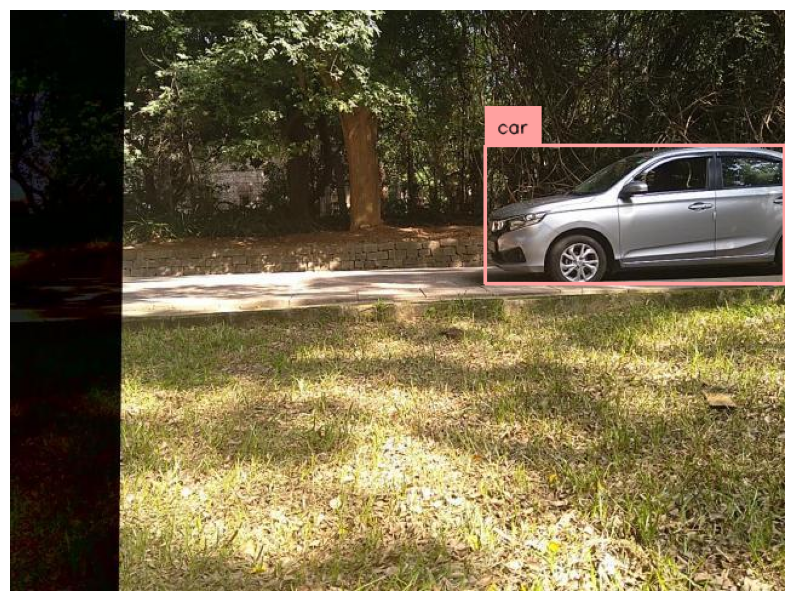

In [16]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Training YOLO v11x Model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from ultralytics import YOLO

# Load a pretrained YOLOv11 model (medium version)
model = YOLO('yolo11x.pt')

# Train the model
results = model.train(
    data="/home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml",  
    epochs=100,
    imgsz=640,
    batch=16,
    name='train11x',  # subfolder name under yolov11_rgb
    project="/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb",
    workers=4,
    verbose=True
)

New https://pypi.org/project/ultralytics/8.3.123 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/home/user/Shivam/dsr_project/dataset/RGB_od/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb, name=train11x, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, au

train: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/train.cache... 21816 images, 669 backgrounds, 1 corrupt: 100%|██████████| 21816/21816 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/user/Shivam/dsr_project/dataset/RGB_od/images/train/000003.jpg: ignoring corrupt image/label: could not convert string to float: 'camouflage_soldier.334375'
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 13, len(boxes) = 49241. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/val.cache... 6233 images, 205 backgrounds, 0 corrupt: 100%|██████████| 6233/6233 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 9, len(boxes) = 13925. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11x/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11x
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      16.6G      1.119      1.549       1.29         54        640: 100%|██████████| 1364/1364 [05:12<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:25<00:00,  7.54it/s]


                   all       6233      13925      0.665      0.519       0.54      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      16.2G      1.201      1.273      1.328         21        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.49it/s]


                   all       6233      13925      0.486      0.445      0.439       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      16.4G       1.37      1.544      1.449         15        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.42it/s]


                   all       6233      13925      0.402      0.367      0.341       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      16.2G      1.428      1.658      1.506         27        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925       0.52      0.419      0.414       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      16.2G      1.348      1.503      1.455         17        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.518       0.46      0.473      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      16.2G      1.296      1.381      1.419         15        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.722      0.454      0.502      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      16.3G      1.259      1.293      1.391         18        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.43it/s]


                   all       6233      13925      0.639      0.521      0.561      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      16.3G      1.222       1.23       1.37         52        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.655      0.527      0.579      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      16.2G        1.2      1.189      1.354         25        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.627      0.562      0.605      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      16.3G      1.173      1.139      1.335         34        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.728      0.575      0.617      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      16.2G       1.15      1.099       1.32         20        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.758      0.571      0.631      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      16.3G       1.14      1.075      1.311         18        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.733       0.59      0.635      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      16.2G      1.129      1.047      1.306         25        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.753        0.6      0.656      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      16.3G      1.107      1.023      1.295         21        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.777      0.597      0.661      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      16.3G      1.098      1.003      1.288         25        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.782      0.604      0.669      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      16.2G      1.088      0.991      1.282         40        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.783      0.616      0.681      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      16.2G      1.079     0.9606      1.278         42        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.781      0.626      0.684      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      16.2G      1.066     0.9488      1.265         14        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.787      0.635      0.712      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      16.2G      1.059     0.9349      1.267         16        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.775      0.655      0.704      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      16.2G      1.046     0.9151      1.255         77        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.802       0.64        0.7        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      16.2G      1.048     0.9055      1.256         22        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925       0.81      0.659      0.716      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      16.2G      1.037      0.901      1.252         34        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.806      0.658      0.738       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      16.2G      1.029     0.8819       1.24         40        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.809      0.669      0.723      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      16.2G      1.019     0.8662      1.232         41        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.792      0.679      0.723      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      16.2G      1.012     0.8614      1.233         30        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.793      0.689      0.736      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      16.3G      1.001     0.8445      1.219         55        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.807      0.689      0.735      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      16.2G     0.9971     0.8361      1.219         25        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.807      0.687      0.738      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      16.2G      0.989     0.8282      1.216         22        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.813      0.692      0.758      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      16.1G     0.9963     0.8173      1.218         40        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.818      0.687      0.758       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      16.2G     0.9824     0.8131      1.209         32        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.822      0.686      0.745      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      16.2G     0.9779     0.7963      1.204         22        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.823      0.691      0.753       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      16.2G     0.9727     0.7945      1.205         25        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.832      0.687      0.757      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      16.3G     0.9642     0.7851        1.2         20        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.816      0.708       0.76      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      16.2G     0.9631     0.7741      1.194         35        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.818      0.707      0.763      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      16.2G     0.9544     0.7703      1.192         34        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.698      0.773      0.764      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      16.2G     0.9482      0.763      1.191         22        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.832      0.698      0.762       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      16.2G     0.9461     0.7608      1.192         26        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.834      0.698      0.758       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      16.2G     0.9398     0.7414      1.183         39        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.828      0.704       0.76      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      16.2G     0.9375     0.7406      1.181         17        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.49it/s]


                   all       6233      13925      0.843      0.696      0.762      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      16.2G     0.9329     0.7322      1.177         29        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.49it/s]


                   all       6233      13925      0.845      0.696      0.763      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      16.1G     0.9282     0.7295      1.178         30        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925       0.76      0.698      0.765      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      16.2G      0.921     0.7134       1.17         27        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.757      0.701      0.768      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      16.3G     0.9185     0.7129       1.17         29        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.761      0.704       0.77      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      16.2G     0.9103      0.712      1.166         29        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.759      0.704       0.77      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      16.1G     0.9046     0.6996      1.163         26        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


                   all       6233      13925      0.745       0.74      0.776      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      16.2G     0.9058     0.6929      1.156         34        640: 100%|██████████| 1364/1364 [05:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.746      0.753      0.776      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      16.1G     0.8966     0.6895      1.154         21        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925       0.76      0.749      0.777      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      16.2G     0.8953     0.6772      1.156         17        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.31it/s]


                   all       6233      13925      0.776      0.748      0.778      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      16.2G     0.8871     0.6669      1.148         24        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925       0.78      0.749      0.778      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      16.2G     0.8811     0.6635      1.144         48        640: 100%|██████████| 1364/1364 [05:05<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:27<00:00,  7.16it/s]


                   all       6233      13925      0.776      0.751      0.779       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      16.2G     0.8833     0.6619       1.14         31        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.36it/s]


                   all       6233      13925      0.774      0.751       0.78      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      16.2G     0.8702     0.6463      1.136         15        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.781      0.747       0.78      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      16.3G     0.8673     0.6457      1.133         17        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.29it/s]


                   all       6233      13925       0.78      0.749      0.781      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      16.2G     0.8627     0.6399      1.131         27        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.37it/s]


                   all       6233      13925      0.784       0.75      0.781      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      16.2G      0.857     0.6365      1.127         33        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.41it/s]


                   all       6233      13925      0.784      0.751      0.782      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      16.2G     0.8514     0.6279      1.124         23        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.35it/s]


                   all       6233      13925      0.784      0.751      0.783      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      16.2G     0.8521     0.6227      1.125         40        640: 100%|██████████| 1364/1364 [05:07<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.40it/s]


                   all       6233      13925      0.781      0.751      0.783      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      16.1G     0.8423     0.6151      1.124         39        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.774      0.752      0.784      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      16.2G     0.8414     0.6163      1.128         15        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.28it/s]


                   all       6233      13925      0.777      0.751      0.784      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      16.2G     0.8344     0.6083       1.12         65        640: 100%|██████████| 1364/1364 [05:07<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.36it/s]


                   all       6233      13925      0.772      0.755      0.795      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      16.2G     0.8295      0.604      1.115         18        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.26it/s]


                   all       6233      13925      0.778      0.751      0.795      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      16.1G     0.8283     0.5951      1.117         41        640: 100%|██████████| 1364/1364 [05:07<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.37it/s]


                   all       6233      13925      0.783      0.748      0.796      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      16.2G     0.8222     0.5907      1.108         25        640: 100%|██████████| 1364/1364 [05:12<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.29it/s]


                   all       6233      13925      0.775      0.752      0.796      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      16.2G     0.8217     0.5871      1.108         15        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:27<00:00,  7.01it/s]

                   all       6233      13925      0.783       0.75      0.797      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      16.2G     0.8125     0.5823      1.101         26        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.22it/s]


                   all       6233      13925       0.79      0.747      0.797      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      16.2G     0.8055      0.573      1.095         46        640: 100%|██████████| 1364/1364 [05:07<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.40it/s]


                   all       6233      13925      0.803      0.743      0.797      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      16.2G     0.8025     0.5742      1.097         29        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.808      0.738      0.798      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      16.2G     0.8036     0.5677      1.097         15        640: 100%|██████████| 1364/1364 [05:15<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.27it/s]


                   all       6233      13925      0.807      0.736      0.798      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      16.2G       0.79     0.5541      1.089         21        640: 100%|██████████| 1364/1364 [05:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:28<00:00,  6.93it/s]

                   all       6233      13925       0.81      0.733      0.798      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      16.2G     0.7882     0.5541       1.09         30        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.816      0.728      0.798      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      16.2G     0.7782     0.5454      1.083         23        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.819      0.725      0.799      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      16.2G     0.7788     0.5402      1.082         58        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.825      0.721      0.799      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      16.3G     0.7726     0.5359      1.081         30        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.40it/s]


                   all       6233      13925      0.827      0.722      0.799      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      16.2G     0.7658     0.5297      1.075         15        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.829      0.722      0.799      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      16.2G     0.7584     0.5232      1.076         32        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.834      0.725        0.8      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      16.3G     0.7603     0.5169       1.07         18        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.41it/s]


                   all       6233      13925       0.83      0.725        0.8      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      16.2G     0.7473     0.5145      1.064         32        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.833      0.726        0.8        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      16.2G     0.7441      0.508      1.065         62        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.847      0.722      0.801      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      16.2G     0.7372     0.5068      1.059         21        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.44it/s]


                   all       6233      13925      0.846      0.724      0.801      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      16.2G     0.7378     0.4993      1.055         23        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:27<00:00,  7.06it/s]


                   all       6233      13925      0.842      0.727      0.801      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      16.2G     0.7321     0.4916      1.055         81        640: 100%|██████████| 1364/1364 [05:14<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.40it/s]


                   all       6233      13925      0.842      0.728      0.802      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      16.2G     0.7237     0.4874      1.049         39        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.37it/s]


                   all       6233      13925      0.838      0.733      0.802      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      16.2G     0.7166     0.4822      1.046         36        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.41it/s]


                   all       6233      13925      0.839      0.734      0.802      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      16.2G     0.7154     0.4803       1.04         35        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.43it/s]


                   all       6233      13925      0.838      0.734      0.802      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      16.2G     0.7081     0.4751      1.036         31        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.841      0.732      0.803      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      16.2G     0.6996     0.4635      1.035         33        640: 100%|██████████| 1364/1364 [05:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.41it/s]


                   all       6233      13925       0.84      0.732      0.803      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      16.2G     0.6984     0.4631      1.036         51        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


                   all       6233      13925      0.838      0.734      0.803      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      16.2G     0.6916      0.459      1.035         26        640: 100%|██████████| 1364/1364 [05:07<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:27<00:00,  7.20it/s]


                   all       6233      13925      0.827      0.739      0.803      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      16.2G     0.6856      0.452      1.028         32        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:25<00:00,  7.50it/s]


                   all       6233      13925      0.825       0.74      0.804      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      16.2G     0.6807     0.4484      1.028         27        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.32it/s]


                   all       6233      13925      0.821      0.742      0.804      0.611
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      16.3G     0.6016     0.3421     0.9711         14        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.47it/s]


                   all       6233      13925      0.819      0.743      0.804      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      16.3G     0.5902     0.3322      0.963         10        640: 100%|██████████| 1364/1364 [05:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.42it/s]


                   all       6233      13925      0.819      0.743      0.804      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      16.2G     0.5822      0.325     0.9607         19        640: 100%|██████████| 1364/1364 [05:13<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.27it/s]


                   all       6233      13925       0.82      0.741      0.804      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      16.3G     0.5718       0.32     0.9586         18        640: 100%|██████████| 1364/1364 [05:12<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.31it/s]


                   all       6233      13925      0.821       0.74      0.804      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      16.2G     0.5665     0.3134     0.9515         14        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.42it/s]


                   all       6233      13925      0.821      0.741      0.804      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      16.2G      0.559     0.3114     0.9492         22        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.38it/s]

                   all       6233      13925      0.822      0.741      0.804      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      16.2G     0.5525      0.305     0.9468          8        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:27<00:00,  7.20it/s]


                   all       6233      13925      0.824       0.74      0.804      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      16.2G     0.5464     0.2999     0.9405         11        640: 100%|██████████| 1364/1364 [05:10<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.46it/s]


                   all       6233      13925      0.824      0.741      0.804      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      16.2G     0.5402     0.2975     0.9391          7        640: 100%|██████████| 1364/1364 [05:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.41it/s]


                   all       6233      13925      0.825      0.741      0.804      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      16.2G     0.5363     0.2936     0.9363          8        640: 100%|██████████| 1364/1364 [05:11<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.41it/s]


                   all       6233      13925      0.825      0.741      0.804      0.615

100 epochs completed in 9.293 hours.
Optimizer stripped from /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11x/weights/last.pt, 114.4MB
Optimizer stripped from /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11x/weights/best.pt, 114.4MB

Validating /home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11x/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)
YOLO11x summary (fused): 464 layers, 56,844,349 parameters, 0 gradients, 194.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:26<00:00,  7.26it/s]


                   all       6233      13925      0.825      0.741      0.804      0.615
                Person        418        807      0.918      0.864      0.949      0.652
                   Car        530       2658      0.838      0.865      0.927      0.755
         Vehicle_Other        314        403      0.924      0.873      0.939      0.751
               Soldier        642       1501      0.805      0.583      0.698      0.463
          Soldier_Camo        806       1069      0.896      0.885      0.935       0.66
      Vehicle_Military        354        775       0.71      0.601      0.684      0.534
                  Tank       1995       3939      0.875      0.885      0.926      0.714
             Artillery         73        103      0.808      0.553      0.658      0.488
                Weapon        222        361      0.874      0.787      0.891      0.714
              Trenches          4          4      0.477       0.25      0.246      0.148
             Air_Asse

## Testing YOLO v11x Model

In [3]:
from ultralytics import YOLO

# Load trained model
model = YOLO('/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb/train11x/weights/best.pt')

# Evaluate on test set
metrics = model.val(
    split='test',
    name='test11x',  #  separate subfolder for test
    project="/home/user/Shivam/dsr_project/Project_files/runs/yolov11_rgb"
)

# Print test metrics
print(metrics)

Ultralytics 8.3.40 🚀 Python-3.12.5 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24184MiB)


YOLO11x summary (fused): 464 layers, 56,844,349 parameters, 0 gradients, 194.5 GFLOPs


val: Scanning /home/user/Shivam/dsr_project/dataset/RGB_od/labels/test.cache... 3117 images, 89 backgrounds, 0 corrupt: 100%|██████████| 3117/3117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:21<00:00,  9.22it/s]


                   all       3117       7164      0.856      0.791      0.853      0.661
                Person        207        427      0.857      0.858      0.923      0.631
                   Car        266       1390      0.809      0.859      0.912      0.741
         Vehicle_Other        141        214      0.895      0.855      0.899      0.724
               Soldier        369        837      0.836      0.574      0.715      0.469
          Soldier_Camo        403        524      0.917      0.909      0.957      0.686
      Vehicle_Military        181        414      0.755      0.633      0.735       0.58
                  Tank        996       1954      0.876      0.909      0.935      0.724
             Artillery         41         76      0.812      0.511      0.597      0.432
                Weapon         91        118      0.886      0.847      0.895      0.742
             Air_Asset        491       1007       0.96      0.809      0.907      0.765
           Naval_Asse